# Project: Weather Dashboard using OpenWeather API

In this project, I'll 
>- Fetch real-time weather data from the OpenWeather API
>- Displays key weather details like temperature, humidity, and conditions
>- Save the data in a CSV file for future analysis
>- Build a simple dashboard using Matplotlib

## Step 1: Get API Key from OpenWeather

## Step 2: Install & Load Required Libraries

In [78]:
# !pip install requests pandas streamlit geopy
#!pip install  geopy
import requests
import time
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import streamlit as st
import seaborn as sns
import numpy as np
import warnings


#warnings.filterwarnings("ignore")
# Suppress FutureWarnings and DeprecationWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

## Step 3: Define Functions for API Calls

In [16]:
# 🔑 OpenWeather API Key (Replace with your own)
API_KEY = "dd8cedb72349b0f32a7715bb048eea3b"

# OpenWeather API URLs
GEO_URL = "http://api.openweathermap.org/geo/1.0/direct"
WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"
FORECAST_URL = "https://api.openweathermap.org/data/2.5/forecast"
HISTORICAL_URL = "https://api.openweathermap.org/data/2.5/onecall/timemachine"

### # 🌍 Get Coordinates for a UK City using OpenWeather's Geocoding API

In [6]:
def get_coordinates(city, country="GB"):
    params = {
        "q": f"{city},{country}",
        "limit": 1,
        "appid": API_KEY
    }
    
    response = requests.get(GEO_URL, params=params)
    
    if response.status_code == 200 and response.json():
        data = response.json()[0]
        return data["lat"], data["lon"]
    else:
        print(f"Error: Could not find coordinates for {city}")
        return None, None


### 🔄 Fetch Past 5 Days of Historical Weather

In [7]:
def get_historical_weather(city, days=5):
    lat, lon = get_coordinates(city)
    if lat is None or lon is None:
        return None

    historical_data = []
    current_time = int(time.time())  # Get current timestamp

    for i in range(days):
        timestamp = current_time - (i * 86400)  # Subtract 1 day per iteration

        params = {
            "lat": lat,
            "lon": lon,
            "dt": timestamp,
            "appid": API_KEY,
            "units": "metric",
        }

        response = requests.get(HISTORICAL_URL, params=params, timeout=10)

        if response.status_code == 200:
            data = response.json()
            if "hourly" in data:
                for entry in data["hourly"]:  # Retrieve hourly past data
                    historical_data.append({
                        "City": city,
                        "Temperature (°C)": entry["temp"],
                        "Humidity (%)": entry["humidity"],
                        "Weather": entry["weather"][0]["description"],
                        "Date": pd.to_datetime(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                    })
            else:
                print(f"⚠️ No hourly data found for {city} on {time.strftime('%Y-%m-%d', time.localtime(timestamp))}")

        else:
            print(f"⚠️ API Error {response.status_code} for {city}: {response.text}")

    return historical_data


### # ☀️ Function to fetch current weather data

In [8]:
def get_weather(city):
    lat, lon = get_coordinates(city)
    if lat is None or lon is None:
        return None

    params = {
        "lat": lat,
        "lon": lon,
        "appid": API_KEY,
        "units": "metric"
    }

    response = requests.get(WEATHER_URL, params=params)

    if response.status_code == 200:
        data = response.json()
        
        return {
            "City": city,
            "Temperature (°C)": data["main"]["temp"],
            "Feels Like (°C)": data["main"]["feels_like"],
            "Pressure (hPa)": data["main"]["pressure"],
            "Humidity (%)": data["main"]["humidity"],
            "Dew Point (°C)": data.get("dew_point", "N/A"),  # Some APIs might not return this
            "UV Index": data.get("uvi", "N/A"),  # Some APIs might not return this
            "Cloud Cover (%)": data["clouds"]["all"],
            "Visibility (m)": data["visibility"],
            "Wind Speed (m/s)": data["wind"]["speed"],
            "Wind Direction (°)": data["wind"]["deg"],
            "Wind Gust (m/s)": data["wind"].get("gust", "N/A"),  # Sometimes missing
            "Sunrise": datetime.datetime.fromtimestamp(data["sys"]["sunrise"]).strftime("%Y-%m-%d %H:%M:%S"),
            "Sunset": datetime.datetime.fromtimestamp(data["sys"]["sunset"]).strftime("%Y-%m-%d %H:%M:%S"),
            "Weather": data["weather"][0]["description"],
            "Date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    else:
        print(f"Error fetching data for {city}: {response.status_code}")
        return None


### ⏳ Function to fetch 5-day forecast data

In [9]:
def get_forecast(city):
    lat, lon = get_coordinates(city)
    if lat is None or lon is None:
        return None

    params = {
        "lat": lat,
        "lon": lon,
        "appid": API_KEY,
        "units": "metric",
        "cnt": 40  # API returns data every 3 hours, so 40 entries for 5 days
    }

    response = requests.get(FORECAST_URL, params=params)

    if response.status_code == 200:
        data = response.json()["list"]
        forecast_data = []

        for entry in data:
            forecast_data.append({
                "City": city,
                "Temperature (°C)": entry["main"]["temp"],
                "Feels Like (°C)": entry["main"]["feels_like"],
                "Pressure (hPa)": entry["main"]["pressure"],
                "Humidity (%)": entry["main"]["humidity"],
                "Dew Point (°C)": entry.get("dew_point", "N/A"),  # May be missing
                "UV Index": entry.get("uvi", "N/A"),  # May be missing
                "Cloud Cover (%)": entry["clouds"]["all"],
                "Visibility (m)": entry.get("visibility", "N/A"),  # Some forecasts might not include this
                "Wind Speed (m/s)": entry["wind"]["speed"],
                "Wind Direction (°)": entry["wind"]["deg"],
                "Wind Gust (m/s)": entry["wind"].get("gust", "N/A"),  # Sometimes missing
                "Weather": entry["weather"][0]["description"],
                "Date": entry["dt_txt"]
            })

        return forecast_data
    else:
        print(f"Error fetching forecast for {city}: {response.status_code}")
        return None


### 📂 Function to save data to CSV

In [10]:
# 📂 Save Weather Data to CSV (Ensures Date is in datetime format)
def save_to_csv(data, filename):
    """Ensures the 'Date' column is converted and avoids empty DataFrames"""
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        df = pd.DataFrame(columns=["City", "Temperature (°C)", "Humidity (%)", "Weather", "Date"])

    # Convert data to DataFrame
    new_data = pd.DataFrame(data)

    # Ensure 'Date' column exists before converting
    if "Date" in new_data.columns and not new_data.empty:
        new_data["Date"] = pd.to_datetime(new_data["Date"])  # Convert Date column

    # ✅ Skip concatenation if `new_data` is empty
    if not new_data.empty:
        df = pd.concat([df, new_data], ignore_index=True)

    df.to_csv(filename, index=False)

    print(f"✅ Data saved to {filename} (Entries: {len(df)})")


## Step 4: Retrieve Weather Data for All UK Cities
-  fetch the history, current weather and 5-day forecast for all UK cities..

### load uk city csv

In [11]:
# Load UK cities dataset (assuming the file has 'city' and 'lat', 'lon' columns)
uk_cities_df = pd.read_csv("gb.csv") 

In [12]:
uk_cities_df.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,London,51.5072,-0.1275,United Kingdom,GB,"London, City of",primary,11262000,8825001
1,Birmingham,52.4800,-1.9025,United Kingdom,GB,Birmingham,NaN,2919600,1137100
2,Portsmouth,50.8058,-1.0872,United Kingdom,GB,Portsmouth,NaN,855679,248440
3,Southampton,50.9025,-1.4042,United Kingdom,GB,Southampton,NaN,855569,271173
4,Nottingham,52.9561,-1.1512,United Kingdom,GB,Nottingham,NaN,729977,289301


In [13]:
uk_cities_df.shape

(258, 9)

In [14]:
# Keep only necessary columns
uk_cities = uk_cities_df["city"].drop_duplicates().values
#uk_cities

### Fetch weather data for each city +historical record

In [ ]:
# Fetch weather data for each city
weather_data_list = []
forecast_data_list = []
historical_weather_list = []

for city in uk_cities[:500]:  # Limit to 500 cities to avoid API rate limits
    weather_data = get_weather(city)
    if weather_data:
        weather_data_list.append(weather_data)

    forecast_data = get_forecast(city)
    if forecast_data:
        forecast_data_list.extend(forecast_data)

    historical_data = get_historical_weather(city)
    if historical_data:
        historical_weather_list.extend(historical_data)
    
    # ✅ Sleep 1 second to prevent exceeding API rate limits
    #time.sleep(1)

# Create DataFrames
weather_df = pd.DataFrame(weather_data_list)
forecast_df = pd.DataFrame(forecast_data_list)
historical_df = pd.DataFrame(historical_weather_list)

# Ensure 'Date' column exists before converting
if 'Date' in weather_df.columns:
    weather_df["Date"] = pd.to_datetime(weather_df["Date"])

if 'Date' in forecast_df.columns:
    forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])

if 'Date' in historical_df.columns:
    historical_df["Date"] = pd.to_datetime(historical_df["Date"])

# Remove empty or all-NA columns
weather_df = weather_df.dropna(axis=1, how='all')
forecast_df = forecast_df.dropna(axis=1, how='all')
historical_df = historical_df.dropna(axis=1, how='all')

# Save to CSV
weather_df.to_csv("uk_weather_data.csv", index=False)
forecast_df.to_csv("uk_weather_forecast.csv", index=False)
historical_df.to_csv("uk_historical_weather.csv", index=False)

### Fetch weather data for each city  

In [18]:
# Fetch weather data for each city
weather_data_list = []
forecast_data_list = []

for city in uk_cities[:500]:  # Limit to 500 cities to avoid API rate limits
    weather_data = get_weather(city)
    if weather_data:
        weather_data_list.append(weather_data)

    forecast_data = get_forecast(city)
    if forecast_data:
        forecast_data_list.extend(forecast_data)

        # ✅ Sleep 1 second to prevent exceeding API rate limits
        #time.sleep(1)

# Create DataFrames
weather_df = pd.DataFrame(weather_data_list)
forecast_df = pd.DataFrame(forecast_data_list)

# Remove empty or all-NA columns
weather_df = weather_df.dropna(axis=1, how='all')
forecast_df = forecast_df.dropna(axis=1, how='all')

# Save to CSV
weather_df.to_csv("uk_weather_data.csv", index=False)
forecast_df.to_csv("uk_weather_forecast.csv", index=False)

Error: Could not find coordinates for Walton upon Thames
Error: Could not find coordinates for Walton upon Thames
Error: Could not find coordinates for Bishops Stortford
Error: Could not find coordinates for Bishops Stortford


## Step 5: View UK Weather Data, clean , Explore & visualise

### Show Current Weather Trends

In [19]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                256 non-null    object 
 1   Temperature (°C)    256 non-null    float64
 2   Feels Like (°C)     256 non-null    float64
 3   Pressure (hPa)      256 non-null    int64  
 4   Humidity (%)        256 non-null    int64  
 5   Dew Point (°C)      256 non-null    object 
 6   UV Index            256 non-null    object 
 7   Cloud Cover (%)     256 non-null    int64  
 8   Visibility (m)      256 non-null    int64  
 9   Wind Speed (m/s)    256 non-null    float64
 10  Wind Direction (°)  256 non-null    int64  
 11  Wind Gust (m/s)     256 non-null    object 
 12  Sunrise             256 non-null    object 
 13  Sunset              256 non-null    object 
 14  Weather             256 non-null    object 
 15  Date                256 non-null    object 
dtypes: float

In [20]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                10240 non-null  object 
 1   Temperature (°C)    10240 non-null  float64
 2   Feels Like (°C)     10240 non-null  float64
 3   Pressure (hPa)      10240 non-null  int64  
 4   Humidity (%)        10240 non-null  int64  
 5   Dew Point (°C)      10240 non-null  object 
 6   UV Index            10240 non-null  object 
 7   Cloud Cover (%)     10240 non-null  int64  
 8   Visibility (m)      10240 non-null  object 
 9   Wind Speed (m/s)    10240 non-null  float64
 10  Wind Direction (°)  10240 non-null  int64  
 11  Wind Gust (m/s)     10240 non-null  float64
 12  Weather             10240 non-null  object 
 13  Date                10240 non-null  object 
dtypes: float64(4), int64(4), object(6)
memory usage: 1.1+ MB


### Data Cleaning & Preprocessing 

In [39]:
# Convert datatypes
forecast_df["Dew Point (°C)"] = pd.to_numeric(forecast_df["Dew Point (°C)"], errors="coerce")
forecast_df["UV Index"] = pd.to_numeric(forecast_df["UV Index"], errors="coerce")
forecast_df["Visibility (m)"] = pd.to_numeric(forecast_df["Visibility (m)"], errors="coerce")
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"], errors="coerce")
forecast_df["City"] = forecast_df["City"].str.strip().str.lower()

# Display updated dtypes
print(forecast_df.dtypes)



City                          object
Temperature (°C)             float64
Feels Like (°C)              float64
Pressure (hPa)                 int64
Humidity (%)                   int64
Dew Point (°C)               float64
UV Index                     float64
Cloud Cover (%)                int64
Visibility (m)               float64
Wind Speed (m/s)             float64
Wind Direction (°)             int64
Wind Gust (m/s)              float64
Weather                       object
Date                  datetime64[ns]
dtype: object


In [40]:
weather_df["Dew Point (°C)"] = pd.to_numeric(weather_df["Dew Point (°C)"], errors="coerce")
weather_df["UV Index"] = pd.to_numeric(weather_df["UV Index"], errors="coerce")
weather_df["Wind Gust (m/s)"] = pd.to_numeric(weather_df["Wind Gust (m/s)"], errors="coerce")
weather_df["Sunrise"] = pd.to_datetime(weather_df["Sunrise"], errors="coerce")
weather_df["Sunset"] = pd.to_datetime(weather_df["Sunset"], errors="coerce")
weather_df["Date"] = pd.to_datetime(weather_df["Date"], errors="coerce")
weather_df["City"] = weather_df["City"].str.strip().str.lower()

# Display updated dtypes
print(weather_df.dtypes)

City                          object
Temperature (°C)             float64
Feels Like (°C)              float64
Pressure (hPa)                 int64
Humidity (%)                   int64
Dew Point (°C)               float64
UV Index                     float64
Cloud Cover (%)                int64
Visibility (m)                 int64
Wind Speed (m/s)             float64
Wind Direction (°)             int64
Wind Gust (m/s)              float64
Sunrise               datetime64[ns]
Sunset                datetime64[ns]
Weather                       object
Date                  datetime64[ns]
dtype: object


In [57]:
# Replace infinite values with NaN across the entire dataset
weather_df.replace([np.inf, -np.inf], np.nan, inplace=True)
forecast_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [58]:
# Drop rows where any critical numeric column has NaN
important_cols = ["Temperature (°C)", "Humidity (%)", "Wind Speed (m/s)", "Pressure (hPa)"]
weather_df.dropna(subset=important_cols, inplace=True)
forecast_df.dropna(subset=important_cols, inplace=True)


In [ ]:
# Ensure no remaining inf values exist
assert not weather_df.isin([np.inf, -np.inf]).values.any(), "Inf values still present in weather_df"
assert not forecast_df.isin([np.inf, -np.inf]).values.any(), "Inf values still present in forecast_df"

print("Inf values successfully removed from both datasets.")

### Exploratory Data Analysis (EDA)
>- Summary statistics (describe(), info()).
>- Identify missing values (isnull().sum()).
>- Distribution of key variables.

In [60]:
# Display basic stats
weather_df.describe()

,Temperature (°C),Feels Like (°C),Pressure (hPa),Humidity (%),Dew Point (°C),UV Index,Cloud Cover (%),Visibility (m),Wind Speed (m/s),Wind Direction (°),Wind Gust (m/s),Sunrise,Sunset,Date
count,256.000000,256.000000,256.000000,256.000000,0.0,0.0,256.000000,256.000000,256.000000,256.000000,194.000000,256,256,256
mean,5.923086,3.661250,1009.355469,82.171875,NaN,NaN,72.328125,9911.910156,3.364141,242.238281,6.150258,2025-02-26 06:58:29.671875072,2025-02-26 17:38:10.707031296,2025-02-26 18:27:24.992187648
min,3.500000,0.940000,1006.000000,47.000000,NaN,NaN,2.000000,888.000000,0.450000,0.000000,1.130000,2025-02-26 06:45:40,2025-02-26 17:25:50,2025-02-26 18:24:39
25%,5.437500,2.722500,1008.000000,79.000000,NaN,NaN,48.000000,10000.000000,1.790000,240.000000,3.115000,2025-02-26 06:52:45.500000,2025-02-26 17:34:58.500000,2025-02-26 18:26:01.500000
50%,5.965000,3.430000,1010.000000,82.000000,NaN,NaN,79.500000,10000.000000,3.525000,253.500000,5.360000,2025-02-26 06:58:26.500000,2025-02-26 17:37:07.500000,2025-02-26 18:27:25
75%,6.445000,4.510000,1010.000000,86.000000,NaN,NaN,97.000000,10000.000000,4.630000,267.000000,9.607500,2025-02-26 07:03:25,2025-02-26 17:40:58.249999872,2025-02-26 18:28:48.500000
max,7.560000,7.560000,1015.000000,97.000000,NaN,NaN,100.000000,10000.000000,10.290000,360.000000,15.430000,2025-02-26 07:20:15,2025-02-26 17:53:18,2025-02-26 18:30:12
std,0.747498,1.341161,1.718016,6.015808,NaN,NaN,27.277401,681.452149,1.874484,58.855971,3.597470,NaN,NaN,NaN


In [61]:
forecast_df.describe()

,Temperature (°C),Feels Like (°C),Pressure (hPa),Humidity (%),Dew Point (°C),UV Index,Cloud Cover (%),Visibility (m),Wind Speed (m/s),Wind Direction (°),Wind Gust (m/s),Date
count,10240.000000,10240.000000,10240.000000,10240.000000,0.0,0.0,10240.000000,10233.000000,10240.00000,10240.000000,10240.000000,10240
mean,5.571970,3.860041,1028.032617,76.134277,NaN,NaN,40.219141,9985.953191,2.63134,254.442871,4.332074,2025-03-01 07:30:00
min,-0.060000,-4.120000,1007.000000,39.000000,NaN,NaN,0.000000,98.000000,0.04000,0.000000,0.010000,2025-02-26 21:00:00
25%,3.770000,1.650000,1027.000000,69.000000,NaN,NaN,5.000000,10000.000000,1.49000,241.000000,1.690000,2025-02-28 02:15:00
50%,5.220000,3.730000,1029.000000,78.000000,NaN,NaN,22.000000,10000.000000,2.13000,272.000000,2.940000,2025-03-01 07:30:00
75%,7.590000,5.830000,1032.000000,85.000000,NaN,NaN,85.000000,10000.000000,3.52000,316.000000,6.610000,2025-03-02 12:45:00
max,12.400000,11.310000,1036.000000,100.000000,NaN,NaN,100.000000,10000.000000,10.71000,360.000000,15.730000,2025-03-03 18:00:00
std,2.536321,2.865901,6.283571,11.773816,NaN,NaN,39.442987,322.992556,1.62703,88.119821,3.404763,NaN


In [62]:
# Check missing values
print(weather_df.isnull().sum())
print(forecast_df.isnull().sum())

City                    0
Temperature (°C)        0
Feels Like (°C)         0
Pressure (hPa)          0
Humidity (%)            0
Dew Point (°C)        256
UV Index              256
Cloud Cover (%)         0
Visibility (m)          0
Wind Speed (m/s)        0
Wind Direction (°)      0
Wind Gust (m/s)        62
Sunrise                 0
Sunset                  0
Weather                 0
Date                    0
dtype: int64
City                      0
Temperature (°C)          0
Feels Like (°C)           0
Pressure (hPa)            0
Humidity (%)              0
Dew Point (°C)        10240
UV Index              10240
Cloud Cover (%)           0
Visibility (m)            7
Wind Speed (m/s)          0
Wind Direction (°)        0
Wind Gust (m/s)           0
Weather                   0
Date                      0
dtype: int64


### Visualizing Trends

### 1. City-wise Comparison (User Input)

In [63]:
# User selects one or multiple cities
selected_cities = input("Enter city names separated by commas: ").split(",")
selected_cities = [city.strip().lower() for city in selected_cities]

# Filter data for selected cities
weather_filtered = weather_df[weather_df["City"].isin(selected_cities)]
forecast_filtered = forecast_df[forecast_df["City"].isin(selected_cities)]

Enter city names separated by commas:  london, crewe


#### Temperature Trends (Actual vs. Forecast)

##### functions

In [84]:
def plot_temperature_trends(weather_filtered, forecast_filtered):
    """Plots Actual vs. Forecast temperature trends for selected cities."""
    
    plt.figure(figsize=(12, 6))

    # Forecast (dashed lines)
    sns.lineplot(data=forecast_filtered, x="Date", y="Temperature (°C)", hue="City", linestyle="dashed")

    # Actual (dots)
    sns.scatterplot(data=weather_filtered, x="Date", y="Temperature (°C)", hue="City", marker="o", s=100, edgecolor="black")

    # Labels
    plt.title("Temperature Trends: Actual vs. Forecast")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")

    # Get city colors from the plot (use only once)
    handles, labels = plt.gca().get_legend_handles_labels()
    city_legend = dict(zip(labels, handles))  # Remove duplicates, keep one per city

    # Create a separate legend for Actual & Forecast
    type_legend = [
        plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=8, label="Actual"),
        plt.Line2D([0], [0], linestyle="dashed", color="black", label="Forecast")
    ]

    # Add both legends below the plot
    plt.legend(
        handles=type_legend + list(city_legend.values()),  # Combine type & city legends
        title="Legend",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),  # Move legend below the chart
        ncol=len(city_legend) + 2,  # Fit all items in a single row
        frameon=False
    )

    # Adjust layout to fit legend
    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # Show plot
    plt.show()

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_humidity_trends(weather_filtered, forecast_filtered):
    """Plots Actual vs. Forecast Humidity Trends for selected cities."""
    
    plt.figure(figsize=(12, 6))

    # Forecast (dashed lines)
    sns.lineplot(data=forecast_filtered, x="Date", y="Humidity (%)", hue="City", linestyle="dashed")

    # Actual (dots)
    sns.scatterplot(data=weather_filtered, x="Date", y="Humidity (%)", hue="City", marker="o", s=100, edgecolor="black")

    # Labels
    plt.title("Humidity Trends: Actual vs. Forecast")
    plt.xlabel("Date")
    plt.ylabel("Humidity (%)")

    # Get city colors from the plot (use only once)
    handles, labels = plt.gca().get_legend_handles_labels()
    city_legend = dict(zip(labels, handles))  # Remove duplicates, keep one per city

    # Create a separate legend for Actual & Forecast
    type_legend = [
        plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=8, label="Actual"),
        plt.Line2D([0], [0], linestyle="dashed", color="black", label="Forecast")
    ]

    # Add both legends below the plot
    plt.legend(
        handles=type_legend + list(city_legend.values()),  # Combine type & city legends
        title="Legend",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),  # Move legend below the chart
        ncol=len(city_legend) + 2,  # Fit all items in a single row
        frameon=False
    )

    # Adjust layout to fit legend
    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # Show plot
    plt.show()


##### plot

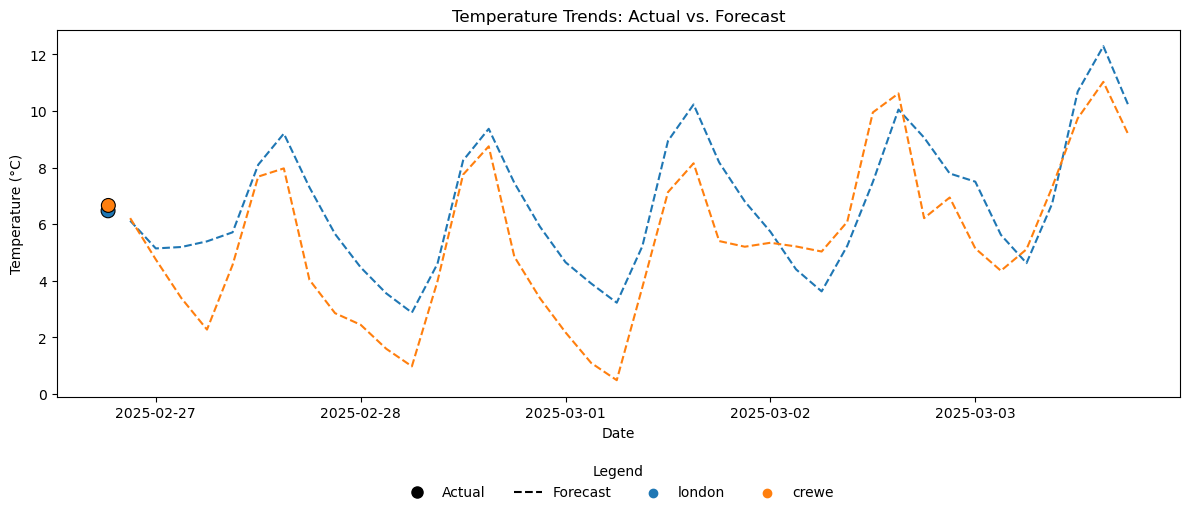

In [85]:
plot_temperature_trends(weather_filtered, forecast_filtered)

#### Humidity, Wind Speed, and Pressure Trends

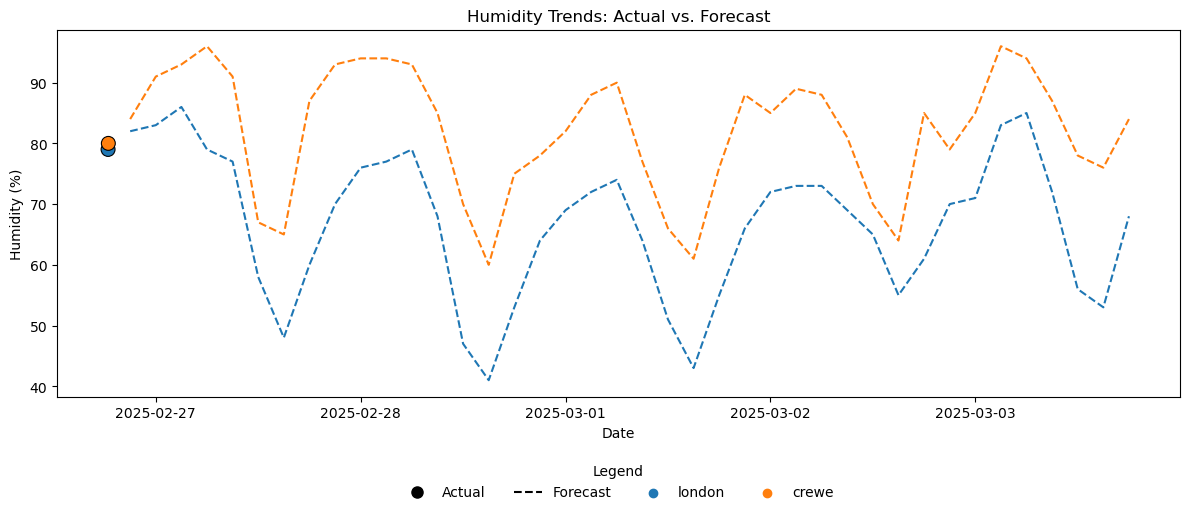

In [92]:
plot_humidity_trends(weather_filtered, forecast_filtered)

## Step 6: Visualizing a UK City Weather Trends

In [87]:
# 🏙️ User input for UK city
city_name = input("Enter a UK city: ")
weather_data_1 = get_weather(city_name)
forecast_data_1 = get_forecast(city_name)

# Convert to DataFrames
weather_df = pd.DataFrame([weather_data_1])  # Wrap in a list to make a DataFrame
forecast_df = pd.DataFrame(forecast_data_1)

# Convert 'Date' column to datetime
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])

Enter a UK city:  dundee


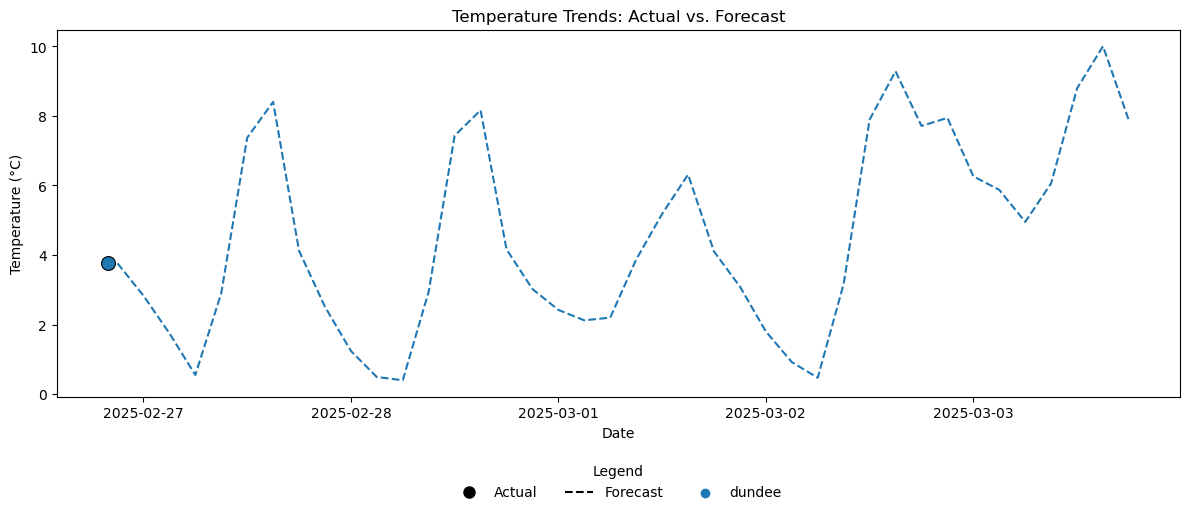

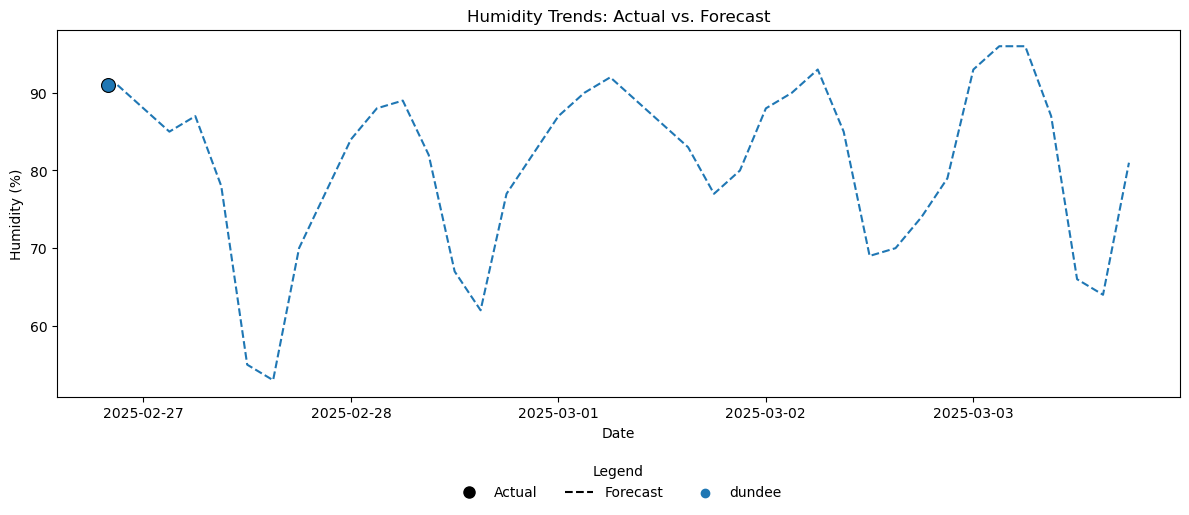

In [96]:
plot_temperature_trends(weather_df, forecast_df)
plot_humidity_trends(weather_df, forecast_df)